In [1]:
import torch
from torch.utils.data import DataLoader as torch_dataloader
from torch.utils.data import Dataset as torch_dataset
from torchvision.utils import make_grid
from torchvision import transforms
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as tt
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
from torchvision.utils import make_grid
from torchvision.transforms import ToTensor

from skimage.transform import resize
import numpy as np
import matplotlib.pyplot as plt
import skimage
import skimage.io as io
import glob
import pandas as pd

In [2]:
class MyDataset(torch_dataset):
    def __init__(self, path, filenamelist, labellist):
        self.path=path
        self.filenamelist=filenamelist
        self.labellist=labellist
    def __len__(self):
        #return the number of data points
        return len(self.filenamelist)
    def __getitem__(self, idx):
        I=io.imread(self.path+self.filenamelist[idx])
        I=skimage.util.img_as_float32(I)
        I = resize(I, (32,32),anti_aliasing=True)
        I = I.reshape(1,I.shape[0],I.shape[1])
        #transform = transforms.Compose([transforms.Resize((32,32)),transforms.ToTensor()])
        I = torch.tensor(I, dtype=torch.float32)
        I = I.expand(3, I.shape[1],I.shape[2])
        label=torch.tensor(self.labellist[idx], dtype=torch.int64)
        return I, label

In [3]:
def get_dataloader():
    df_train=pd.read_csv('train.csv')
    df_val=pd.read_csv('val.csv')
    df_test=pd.read_csv('test.csv')

    path='New folder//'

    dataset_train = MyDataset(path, df_train['filename'].values, df_train['label'].values)
    dataset_val = MyDataset(path, df_val['filename'].values, df_val['label'].values)
    dataset_test = MyDataset(path, df_test['filename'].values, df_test['label'].values)

    loader_train = torch_dataloader(dataset_train, batch_size=32, num_workers=0, shuffle=True, pin_memory=True)
    loader_val = torch_dataloader(dataset_val, batch_size=32, num_workers=0, shuffle=True, pin_memory=True)
    loader_test = torch_dataloader(dataset_test, batch_size=32, num_workers=0, shuffle=True, pin_memory=True)
    
    return loader_train,loader_val,loader_test

In [4]:
train,val,test  = get_dataloader()

C:\Users\deep\AppData\Local\Temp/ipykernel_28132/1481772481.py:17: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label=torch.tensor(self.labellist[idx], dtype=torch.int64)


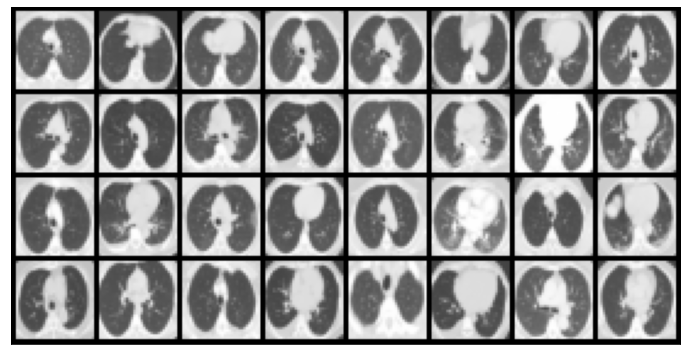

In [5]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break
        
show_batch(train)

# Basic from Scratch CNN

In [6]:
class ImageClassificationBase(nn.Module):
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [7]:
class NaturalSceneClassification(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            
            nn.Conv2d(3, 32, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(32,64, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
        
            nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(128 ,128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(256,256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Flatten(),
            nn.Linear(4096,1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512,2)
        )
    
    def forward(self, xb):
        return self.network(xb)
model = NaturalSceneClassification()

In [8]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

  
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

  
def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD):
    
    history = []
    optimizer = opt_func(model.parameters(),lr)
    for epoch in range(epochs):
        
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    
    return history

In [9]:
num_epochs = 20
opt_func = torch.optim.Adam
lr = 0.0001

In [10]:
history = fit(num_epochs, lr, model, train, val, opt_func)

C:\Users\deep\AppData\Local\Temp/ipykernel_39860/1481772481.py:17: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label=torch.tensor(self.labellist[idx], dtype=torch.int64)


Epoch [0], train_loss: 0.6818, val_loss: 0.6978, val_acc: 0.5893
Epoch [1], train_loss: 0.5978, val_loss: 0.6314, val_acc: 0.6138
Epoch [2], train_loss: 0.5367, val_loss: 0.6189, val_acc: 0.6473
Epoch [3], train_loss: 0.5095, val_loss: 0.5815, val_acc: 0.6853
Epoch [4], train_loss: 0.4831, val_loss: 0.5288, val_acc: 0.7924
Epoch [5], train_loss: 0.4036, val_loss: 0.6441, val_acc: 0.7188
Epoch [6], train_loss: 0.3826, val_loss: 0.4375, val_acc: 0.8638
Epoch [7], train_loss: 0.3280, val_loss: 0.5620, val_acc: 0.7433
Epoch [8], train_loss: 0.3492, val_loss: 0.3742, val_acc: 0.8817
Epoch [9], train_loss: 0.2612, val_loss: 0.3591, val_acc: 0.9308
Epoch [10], train_loss: 0.2440, val_loss: 0.3694, val_acc: 0.8817
Epoch [11], train_loss: 0.2101, val_loss: 0.4780, val_acc: 0.8214
Epoch [12], train_loss: 0.2879, val_loss: 0.3431, val_acc: 0.8951
Epoch [13], train_loss: 0.1944, val_loss: 0.4615, val_acc: 0.8817
Epoch [14], train_loss: 0.1717, val_loss: 0.3671, val_acc: 0.8973
Epoch [15], train_lo

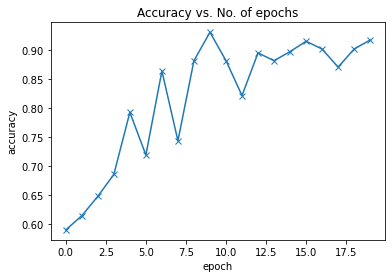

In [11]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');
plot_accuracies(history)

In [12]:
model.eval()  # it-disables-dropout
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
          
    print('Test Accuracy of the model: {} %'.format(100 * correct / total))

C:\Users\deep\AppData\Local\Temp/ipykernel_39860/1481772481.py:17: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label=torch.tensor(self.labellist[idx], dtype=torch.int64)


Test Accuracy of the model: 95.0 %


# Transfer Learning

In [13]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))
        
class Resnet18(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet18(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, 2)
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))
    
    def freeze(self):
        # To freeze the residual layers
        for param in self.network.parameters():
            param.require_grad = False
        for param in self.network.fc.parameters():
            param.require_grad = True
    
    def unfreeze(self):
        # Unfreeze all layers
        for param in self.network.parameters():
            param.require_grad = True
model_res = Resnet18()

C:\Users\deep\anaconda3\envs\myenv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\deep\anaconda3\envs\myenv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [14]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [15]:
epochs = 10
max_lr = 0.0001
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam
history = []
history += fit_one_cycle(epochs, max_lr, model_res, train, test, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

C:\Users\deep\AppData\Local\Temp/ipykernel_39860/1481772481.py:17: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label=torch.tensor(self.labellist[idx], dtype=torch.int64)


Epoch [0], last_lr: 0.00003, train_loss: 0.6722, val_loss: 0.6409, val_acc: 0.6851
Epoch [1], last_lr: 0.00008, train_loss: 0.5343, val_loss: 0.4554, val_acc: 0.8702
Epoch [2], last_lr: 0.00010, train_loss: 0.4145, val_loss: 0.4079, val_acc: 0.9038
Epoch [3], last_lr: 0.00010, train_loss: 0.3785, val_loss: 0.3825, val_acc: 0.9351
Epoch [4], last_lr: 0.00008, train_loss: 0.3535, val_loss: 0.3705, val_acc: 0.9423
Epoch [5], last_lr: 0.00006, train_loss: 0.3451, val_loss: 0.3779, val_acc: 0.9327
Epoch [6], last_lr: 0.00004, train_loss: 0.3374, val_loss: 0.3631, val_acc: 0.9543
Epoch [7], last_lr: 0.00002, train_loss: 0.3350, val_loss: 0.3553, val_acc: 0.9591
Epoch [8], last_lr: 0.00000, train_loss: 0.3289, val_loss: 0.3571, val_acc: 0.9543
Epoch [9], last_lr: 0.00000, train_loss: 0.3264, val_loss: 0.3577, val_acc: 0.9567


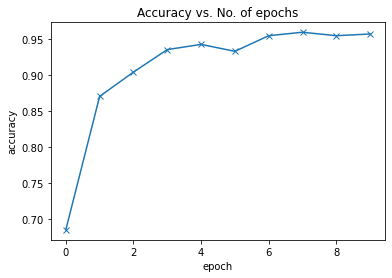

In [16]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')
plot_accuracies(history)

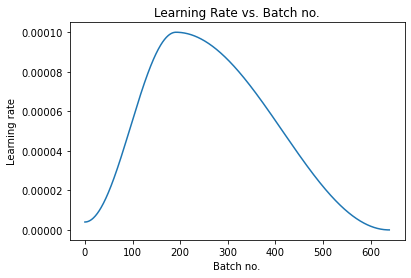

In [17]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');
plot_lrs(history)

In [18]:
model_res.eval()  # it-disables-dropout
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test:
        outputs = model_res(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
          
    print('Test Accuracy of the model: {} %'.format(100 * correct / total))

C:\Users\deep\AppData\Local\Temp/ipykernel_39860/1481772481.py:17: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label=torch.tensor(self.labellist[idx], dtype=torch.int64)


Test Accuracy of the model: 95.75 %


### Resnet18 is giving better accuracy than the predefined model.

In [19]:
from pytorch_grad_cam import GradCAM,EigenCAM
from pytorch_grad_cam.utils.model_targets import BinaryClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from PIL import Image

In [20]:
I1=io.imread("New folder\COVID\Covid (1).png")
I1=skimage.util.img_as_float32(I1)
I1 = resize(I1, (32,32,3),anti_aliasing=True)
#I1 = I1.reshape(1,I1.shape[0],I1.shape[1])

I=io.imread("New folder\COVID\Covid (1).png")
I=skimage.util.img_as_float32(I)
I = resize(I, (32,32),anti_aliasing=True)
I = I.reshape(1,I.shape[0],I.shape[1])
I = torch.tensor(I, dtype=torch.float32)
I = I.expand(1,3, I.shape[1],I.shape[2])
input_tensor = I

CAM for Reset18 model

In [21]:
target_layers = [model_res.network.layer4[-1]]
e_cam = EigenCAM(model=model_res, target_layers=target_layers)
g_cam = GradCAM(model=model_res, target_layers=target_layers)

e_grayscale_cam = e_cam(input_tensor=input_tensor)
g_grayscale_cam = g_cam(input_tensor=input_tensor)

e_grayscale_cam = e_grayscale_cam[0, :]
g_grayscale_cam = g_grayscale_cam[0, :]

e_visualization = show_cam_on_image(I1, e_grayscale_cam, use_rgb=True)
g_visualization = show_cam_on_image(I1, g_grayscale_cam, use_rgb=True)

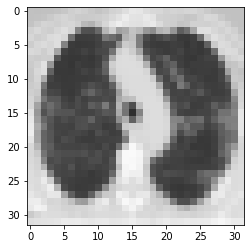

In [22]:
plt.imshow(I1)

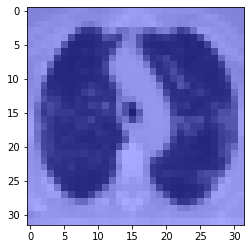

In [23]:
plt.imshow(e_visualization)

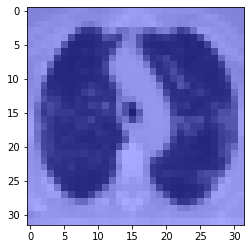

In [24]:
plt.imshow(g_visualization)

CAM for Scratch model

In [25]:
target_layers = [model.network[12]]
e_cam = EigenCAM(model=model, target_layers=target_layers)
g_cam = GradCAM(model=model, target_layers=target_layers)

e_grayscale_cam = e_cam(input_tensor=input_tensor)
g_grayscale_cam = g_cam(input_tensor=input_tensor)

e_grayscale_cam = e_grayscale_cam[0, :]
g_grayscale_cam = g_grayscale_cam[0, :]

e_visualization = show_cam_on_image(I1, e_grayscale_cam, use_rgb=True)
g_visualization = show_cam_on_image(I1, g_grayscale_cam, use_rgb=True)

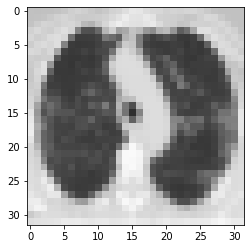

In [26]:
plt.imshow(I1)

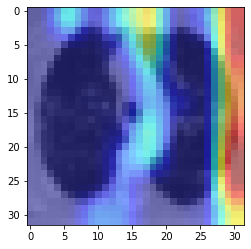

In [27]:
plt.imshow(e_visualization)

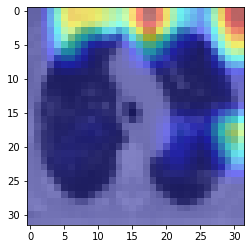

In [28]:
plt.imshow(g_visualization)